# 0. IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from statsmodels.graphics.mosaicplot import mosaic

import scipy.stats as SS

from sklearnex import patch_sklearn; patch_sklearn()
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost
from sklearn.model_selection import KFold

import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
from IPython.display import display, HTML
from os import remove
import pickle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 0.1. Helper Funcions

df5['Response'].count_values

In [2]:
def cramer_v(df1, df2):  
    confusion_matrix = pd.crosstab(df1, df2).values
    chi2 = SS.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))



def precision_top_k(df, k):
    return df['Response'].head(k).sum()/k



def average_precision_at_k(df, k):
    def calc():
        for i in range(1, k + 1):
            yield precision_top_k(df, i)
            
    return np.mean(list(calc()))



def ml_result(val, k, model_name, prediction):
    df = val.copy()
    df['PropensityScore'] = prediction[:, 1]
    df = df.sort_values(by = "PropensityScore", ascending = False)

    p_at_k = precision_top_k(df, k)
    ap_at_k = average_precision_at_k(df, k)

    return pd.DataFrame([[model_name, p_at_k, ap_at_k]], columns = ['Model', "Precision@{}".format(k), "AP@{}".format(k)], index = [0])



def cross_validation(df, n_folds, model, name, verbose = False):
    kf = KFold(n_splits = n_folds, random_state = seed, shuffle = True)

    result_df = pd.DataFrame([])
    for i, (train_index, val_index) in enumerate(kf.split(df)):
        train = df.iloc[train_index, :]
        val = df.iloc[val_index, :]

        x_train = train.drop('Response', axis = 1)
        y_train = train['Response']

        x_val = val.drop('Response', axis = 1)
        y_val = val['Response']


        model.fit(x_train, y_train)

        prediction = model.predict_proba(x_val)

        result_fold = ml_result(val, k, name, prediction)
        result_df = pd.concat([result_df, result_fold])
        
        if verbose == True:
            print(result_fold)
        
    means = result_df.iloc[:, 1:].mean()
    stds = result_df.iloc[:, 1:].std()

    result = pd.DataFrame([name, '{:.4f} +/- {:.4f}'.format(means[0], stds[0]), '{:.4f} +/- {:.4f}'.format(means[1], stds[1]) ], index = list(result_df.columns)).T
    
    return result

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')

display(HTML("<style>.container { width:100% !important; }</style>"))

seed = 0

## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.dataset_download_files('anmolkumar/health-insurance-cross-sell-prediction', unzip = True);

df_raw = pd.read_csv('train.csv', encoding = 'unicode_escape')
df_final_test = pd.read_csv('test.csv', encoding = 'unicode_escape')

remove('train.csv')
remove('test.csv')
remove('sample_submission.csv')

## 0.4. Train Test Split

In [5]:
df_train_val_raw, df_test_raw = train_test_split(df_raw, train_size = 0.8, shuffle = True, random_state = seed)

# 1. DATA DESCRIPTION

In [6]:
df1 = df_train_val_raw.copy()

## 1.1. Rename Columns

In [7]:
new_cols_name = ['ID', 'Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
                 'HaveInsurance', 'VehicleAge', 'HaveDamagedVehicle', 'AnnualCost',
                 'CommunicationChannel', 'CustomerSinceDays', 'Response']
df1.columns = new_cols_name

## 1.2. Data Dimensions

In [8]:
n_rows, n_cols = df1.shape

print('Number of Rows: {}\nNumber of Columns: {}'.format(n_rows, n_cols))

Number of Rows: 304887
Number of Columns: 12


## 1.3. Data Types

In [9]:
df1.dtypes

ID                        int64
Gender                   object
Age                       int64
HaveDrivingLicense        int64
RegionCode              float64
HaveInsurance             int64
VehicleAge               object
HaveDamagedVehicle       object
AnnualCost              float64
CommunicationChannel    float64
CustomerSinceDays         int64
Response                  int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

ID                      0
Gender                  0
Age                     0
HaveDrivingLicense      0
RegionCode              0
HaveInsurance           0
VehicleAge              0
HaveDamagedVehicle      0
AnnualCost              0
CommunicationChannel    0
CustomerSinceDays       0
Response                0
dtype: int64

## 1.5 Fillout NA

## 1.6. Changing Data Types

In [11]:
# RegionCode
df1['RegionCode'] = df1['RegionCode'].astype('object')

# HaveDamagedVehicle
df1['HaveDamagedVehicle'] = df1['HaveDamagedVehicle'].map({'Yes': 1, 'No': 0 })

# CommunicationChannel
df1['CommunicationChannel'] = df1['CommunicationChannel'].astype('object')

## 1.7. Descriptive Analysis

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop("ID", axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1. Numerical Attributes

In [13]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [14]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
Age,20.0,85.0,65.0,38.821127,36.0,15.504253,0.672074,-0.566798
HaveDrivingLicense,0.0,1.0,1.0,0.997871,1.0,0.046088,-21.605240,464.789436
HaveInsurance,0.0,1.0,1.0,0.458285,0.0,0.498257,0.167446,-1.971975
HaveDamagedVehicle,0.0,1.0,1.0,0.504715,1.0,0.499978,-0.018860,-1.999657
AnnualCost,2630.0,540165.0,537535.0,30578.576873,31684.0,17196.830459,1.695928,31.490580
CustomerSinceDays,10.0,299.0,289.0,154.190539,154.0,83.716529,0.005773,-1.202021
Response,0.0,1.0,1.0,0.122452,0.0,0.327807,2.303489,3.306083


### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.describe().T

,count,unique,top,freq
Gender,304887,2,Male,164789
RegionCode,304887.0,53.0,28.0,85135.0
VehicleAge,304887,3,1-2 Year,160155
CommunicationChannel,304887.0,154.0,152.0,107895.0


# 2. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Hypotheses

**H1.** Most of the customers who are interested in insurance are over 45 years old.

**H2.** Longer-term customers tend to be interested in insurance.

**H3.** There is a positive correlation between the car's age and the insurance cost.

**H4.** On average, men are more interested in car insurance than women.

**H5.** On average, people who have damaged their car tend to be more interested in car insurance.

**H6.** Customers tend to lose interest when the cost of insurance increases.

## 2.2. Feature Creation

# 3. VARIABLE FILTERING

In [17]:
df3 = df2.copy()

## 3.1. Row Filtering

## 3.2. Columns Filtering

In [18]:
df3 = df3.drop('ID', axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [19]:
df4 = df3.copy()

In [20]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
df4_cat = df4.select_dtypes(exclude = ['int64', 'float64'])
df4_cat['Response'] = df4['Response']

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

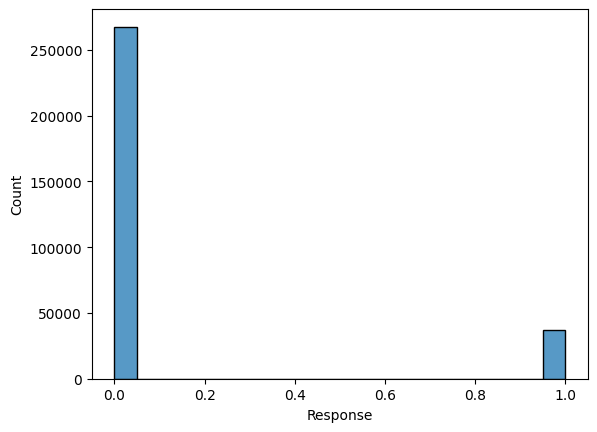

In [21]:
sns.histplot(df4["Response"]);

### 4.1.2. Numerical Attributes

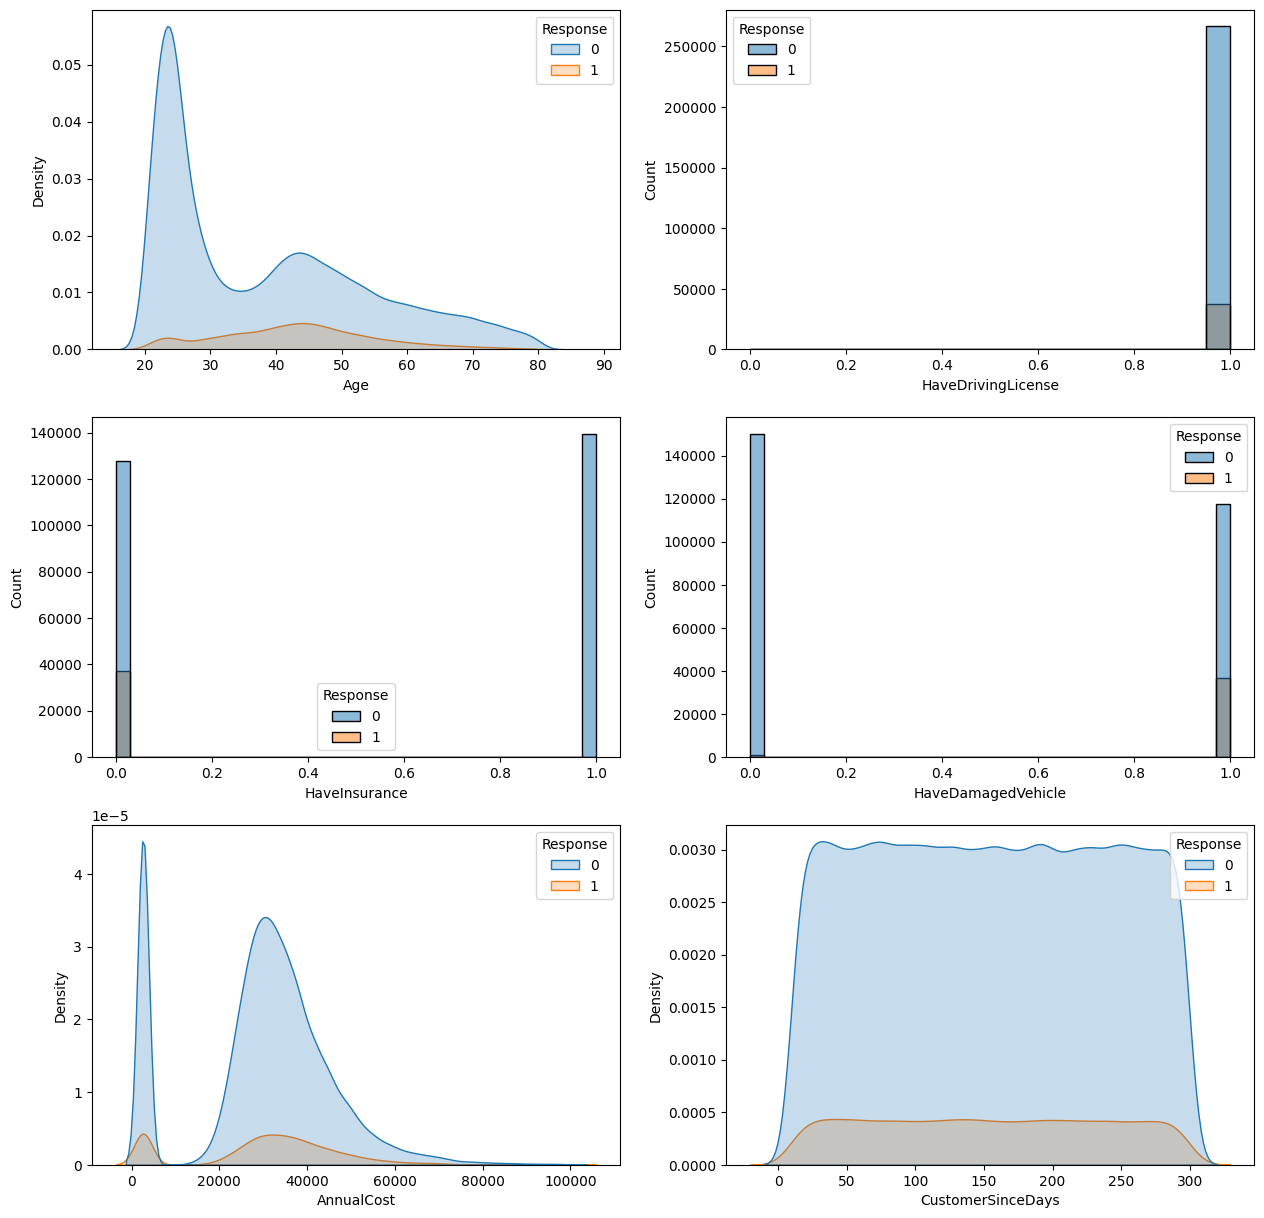

In [22]:
plt.subplots(3, 2, figsize = [15, 15])

# Age
plt.subplot(3, 2, 1)
sns.kdeplot(x = 'Age', hue = 'Response', data = df4_num, fill = True)

# HaveDrivingLicense
plt.subplot(3, 2, 2)
sns.histplot(x = "HaveDrivingLicense", hue = "Response", data = df4_num)

# PreviouslyInsured
plt.subplot(3, 2, 3)
sns.histplot(x = 'HaveInsurance', hue = 'Response', data = df4_num)

# HaveDamagedVehicle
plt.subplot(3, 2, 4)
sns.histplot(x = 'HaveDamagedVehicle', hue = 'Response', data = df4_num)

# AnnualCost
plt.subplot(3, 2, 5)
aux = df4_num[df4_num['AnnualCost'] < 100000]
sns.kdeplot(x = 'AnnualCost', hue = 'Response', data = aux, fill = True)

# CustomerSinceDays
plt.subplot(3, 2, 6)
sns.kdeplot(x = 'CustomerSinceDays', hue = 'Response', data = df4_num, fill = True);

### 4.1.3. Categorical Attributes

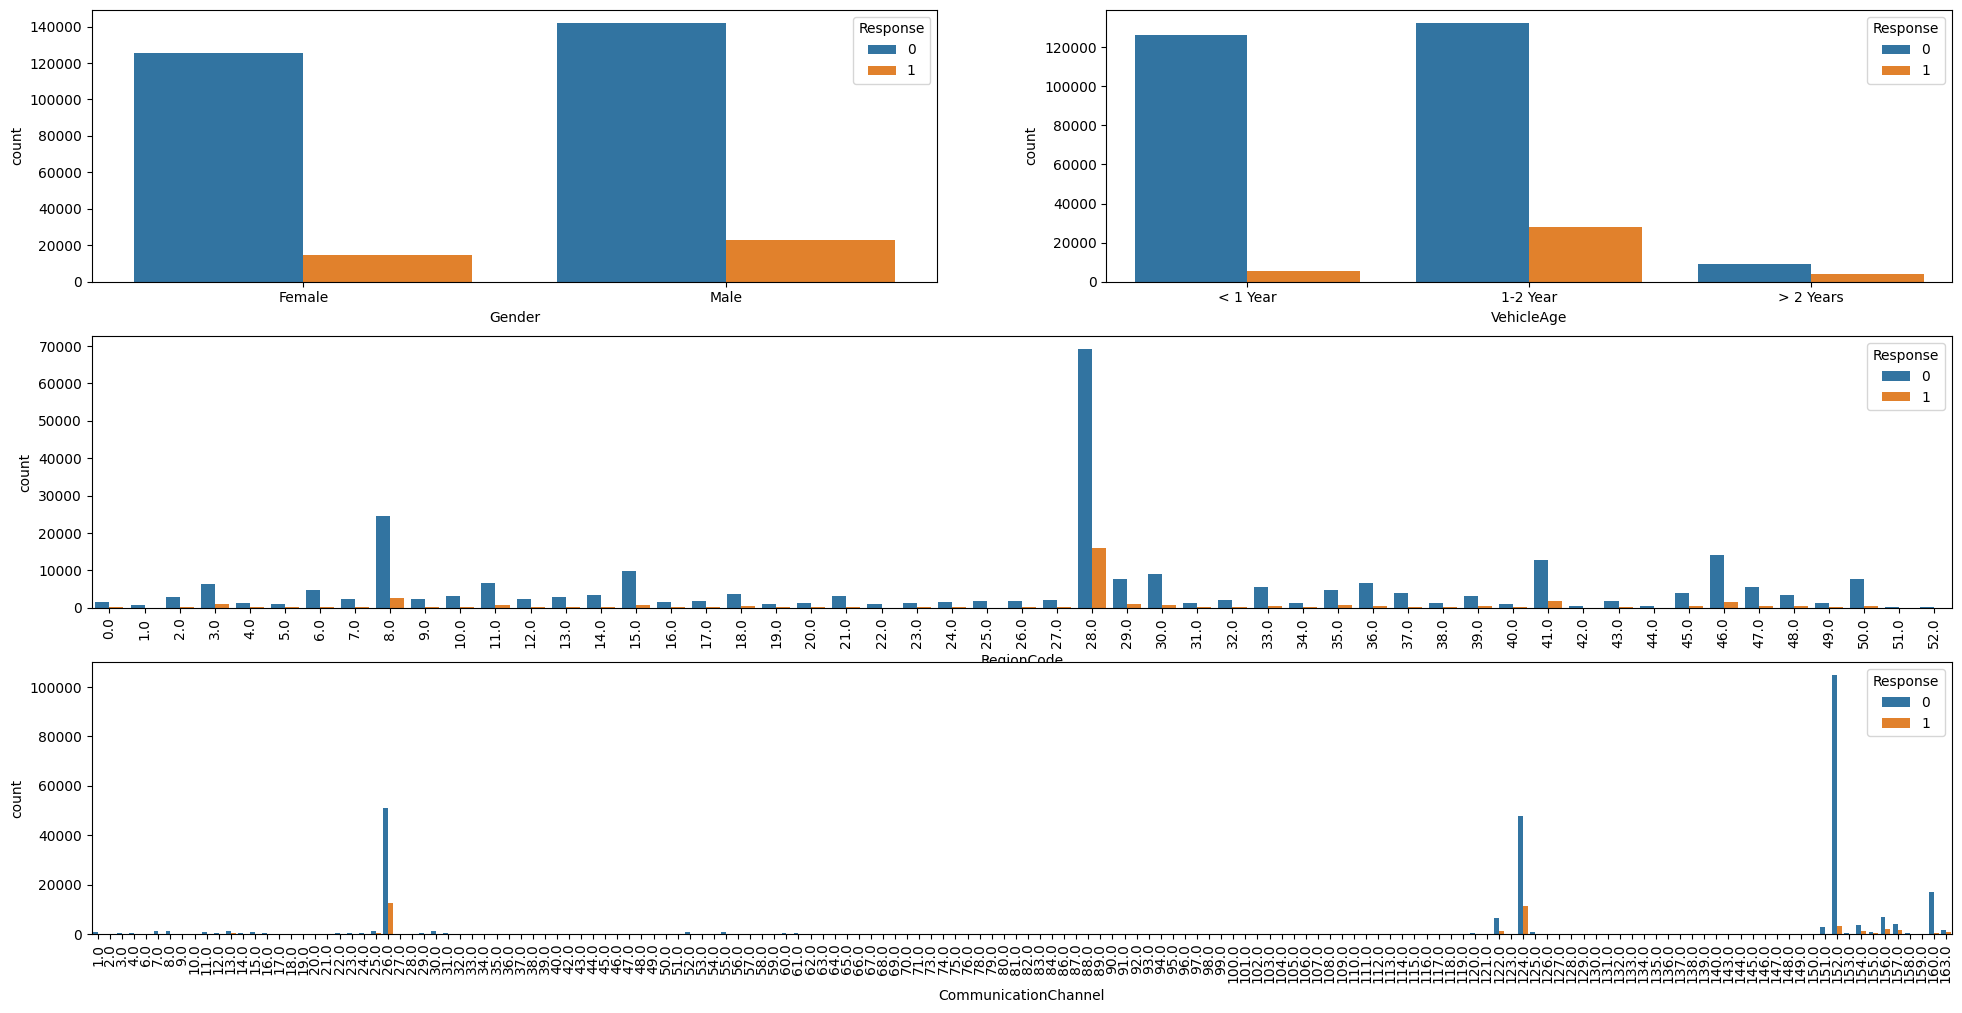

In [23]:
plt.subplots(3, 2, figsize = [24, 12])

# Gender
plt.subplot(3, 2, 1)
sns.countplot(x = 'Gender', data = df4_cat, hue = "Response")

# VehicleAge
plt.subplot(3, 2, 2)
sns.countplot(x = 'VehicleAge', data = df4_cat, hue = "Response")

# RegionCode
plt.subplot(3, 1, 2)
sns.countplot(x = 'RegionCode', data = df4_cat, hue = "Response")
plt.xticks(rotation = 90)

# CommunicationChannel
ax = plt.subplot(3, 1, 3)
ax = sns.countplot(x = 'CommunicationChannel', data = df4_cat, hue = 'Response')
plt.xticks(rotation = 90);

## 4.2. Bivariate Analysis

### 4.2.1. Hypotheses Check

**H1.** Most of the customers who are interested in insurance are over 45 years old.

**False:** Most of interested customer are below 45 years old.

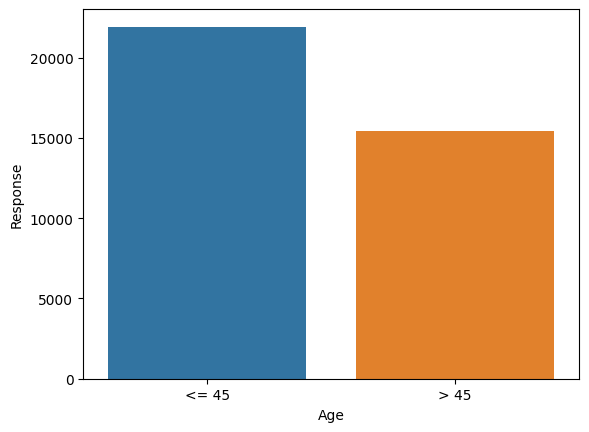

In [24]:
aux = df4[['Age', 'Response']]
aux["Age"] = aux['Age'].apply(lambda x: "> 45" if x > 45 else "<= 45")

aux2 = aux.groupby('Age').sum().reset_index()

sns.barplot(x = 'Age', y = 'Response', data = aux2);

**H2.** There is a positive correlation between CustomerSinceDays and whether they are interested or not in the insurance.

**False:** There is no correlation between both variables.

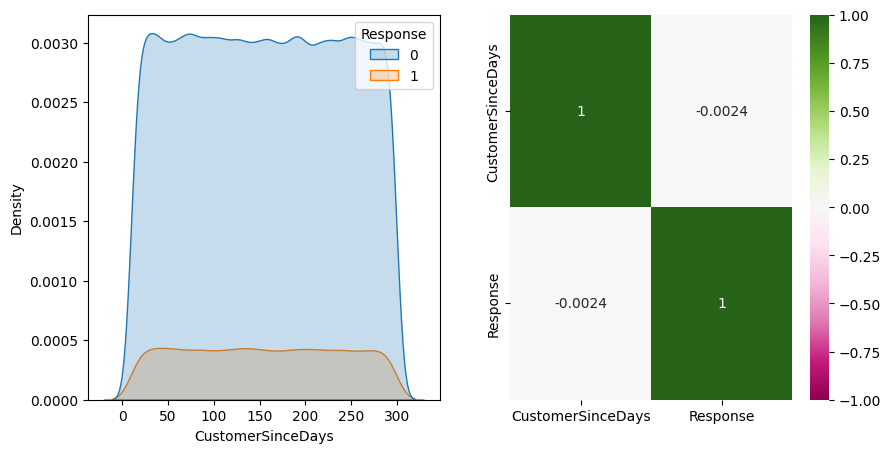

In [25]:
plt.subplots(1, 2, figsize = [10, 5])

# KDEplot
plt.subplot(1, 2, 1)
sns.kdeplot(x = "CustomerSinceDays", data = df4, hue = 'Response', fill = True)

plt.subplot(1, 2, 2)
sns.heatmap(df4[['CustomerSinceDays', "Response"]].corr(), vmin = -1, vmax = 1, cmap = "PiYG", annot = True);

**H3.** There is a positive correlation between the car's age and the insurance cost.

**True:** The older the vehicle, the more likely is the owner to be interested in the insurance.

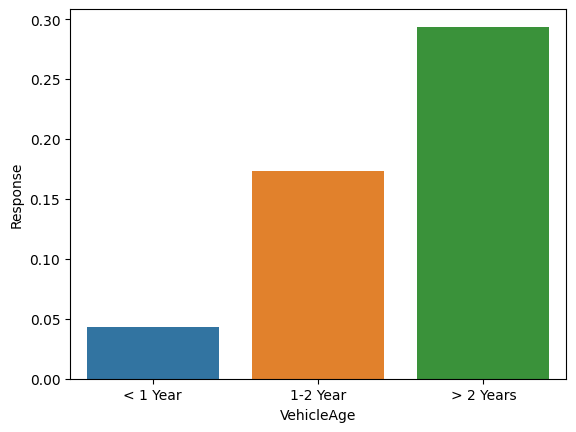

In [26]:
aux = df4[['VehicleAge', 'Response']].groupby("VehicleAge").sum()
aux2 = df4[['VehicleAge', 'Response']].groupby("VehicleAge").count()
aux3 = (aux/aux2).reset_index()
aux3 = aux3.sort_values(by = 'Response', ascending = True)

sns.barplot(x = "VehicleAge", y = 'Response', data = aux3);

**H4.** On average, men are more interested in car insurance than women.

**True:** They are more interested.

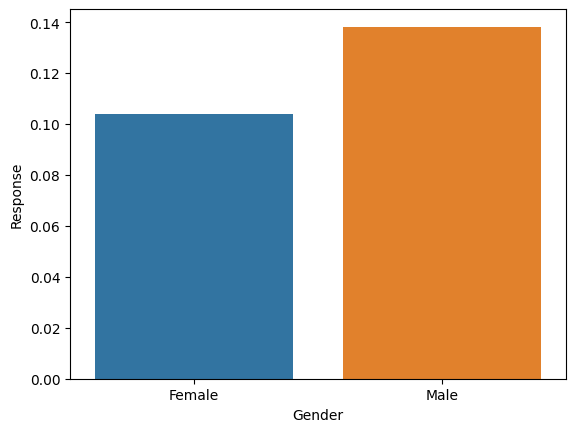

In [27]:
aux = df4[['Gender', 'Response']].groupby("Gender").sum()
aux2 = df4[['Gender', 'Response']].groupby("Gender").count()
aux3 = (aux/aux2).reset_index()

sns.barplot(x = 'Gender' , y = 'Response', data = aux3);

**H5.** On average, people who have damaged their car tend to be more interested in car insurance.

**True:** There is a slight positive correlation between variables.

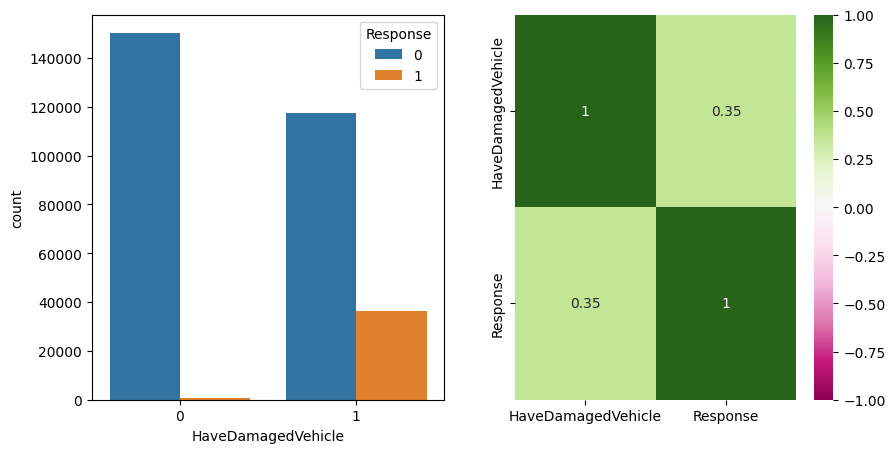

In [28]:
plt.subplots(1, 2, figsize = [10, 5])

# Countplot
plt.subplot(1, 2, 1)
sns.countplot(x = "HaveDamagedVehicle", data = df4, hue = 'Response')

# HeatMap -- Correlation
plt.subplot(1, 2, 2)
sns.heatmap(df4[['HaveDamagedVehicle', "Response"]].corr(), vmin = -1, vmax = 1, cmap = "PiYG", annot = True);

**H6.** Customers tend to lose interest when the cost of insurance increases.

**False:** There is no relation between those variables.

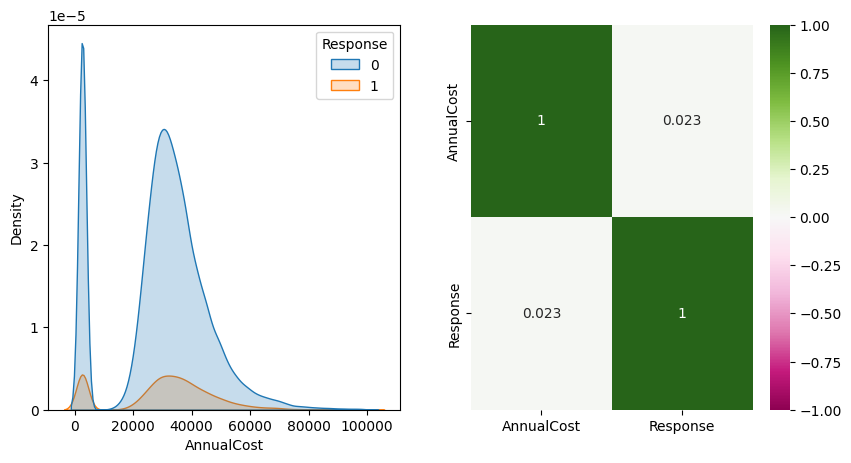

In [29]:
aux = df4.copy()
aux = df4[df4['AnnualCost'] < 100000]

plt.subplots(1, 2, figsize = [10, 5])

# KDE Plot
plt.subplot(1, 2, 1)
sns.kdeplot(x = 'AnnualCost', hue = 'Response', data = aux, fill = True)

# Heatmap Corr
plt.subplot(1, 2, 2)
sns.heatmap(df4[['AnnualCost', "Response"]].corr(), vmin = -1, vmax = 1, cmap = "PiYG", annot = True);

### 4.2.2. Pair Plot

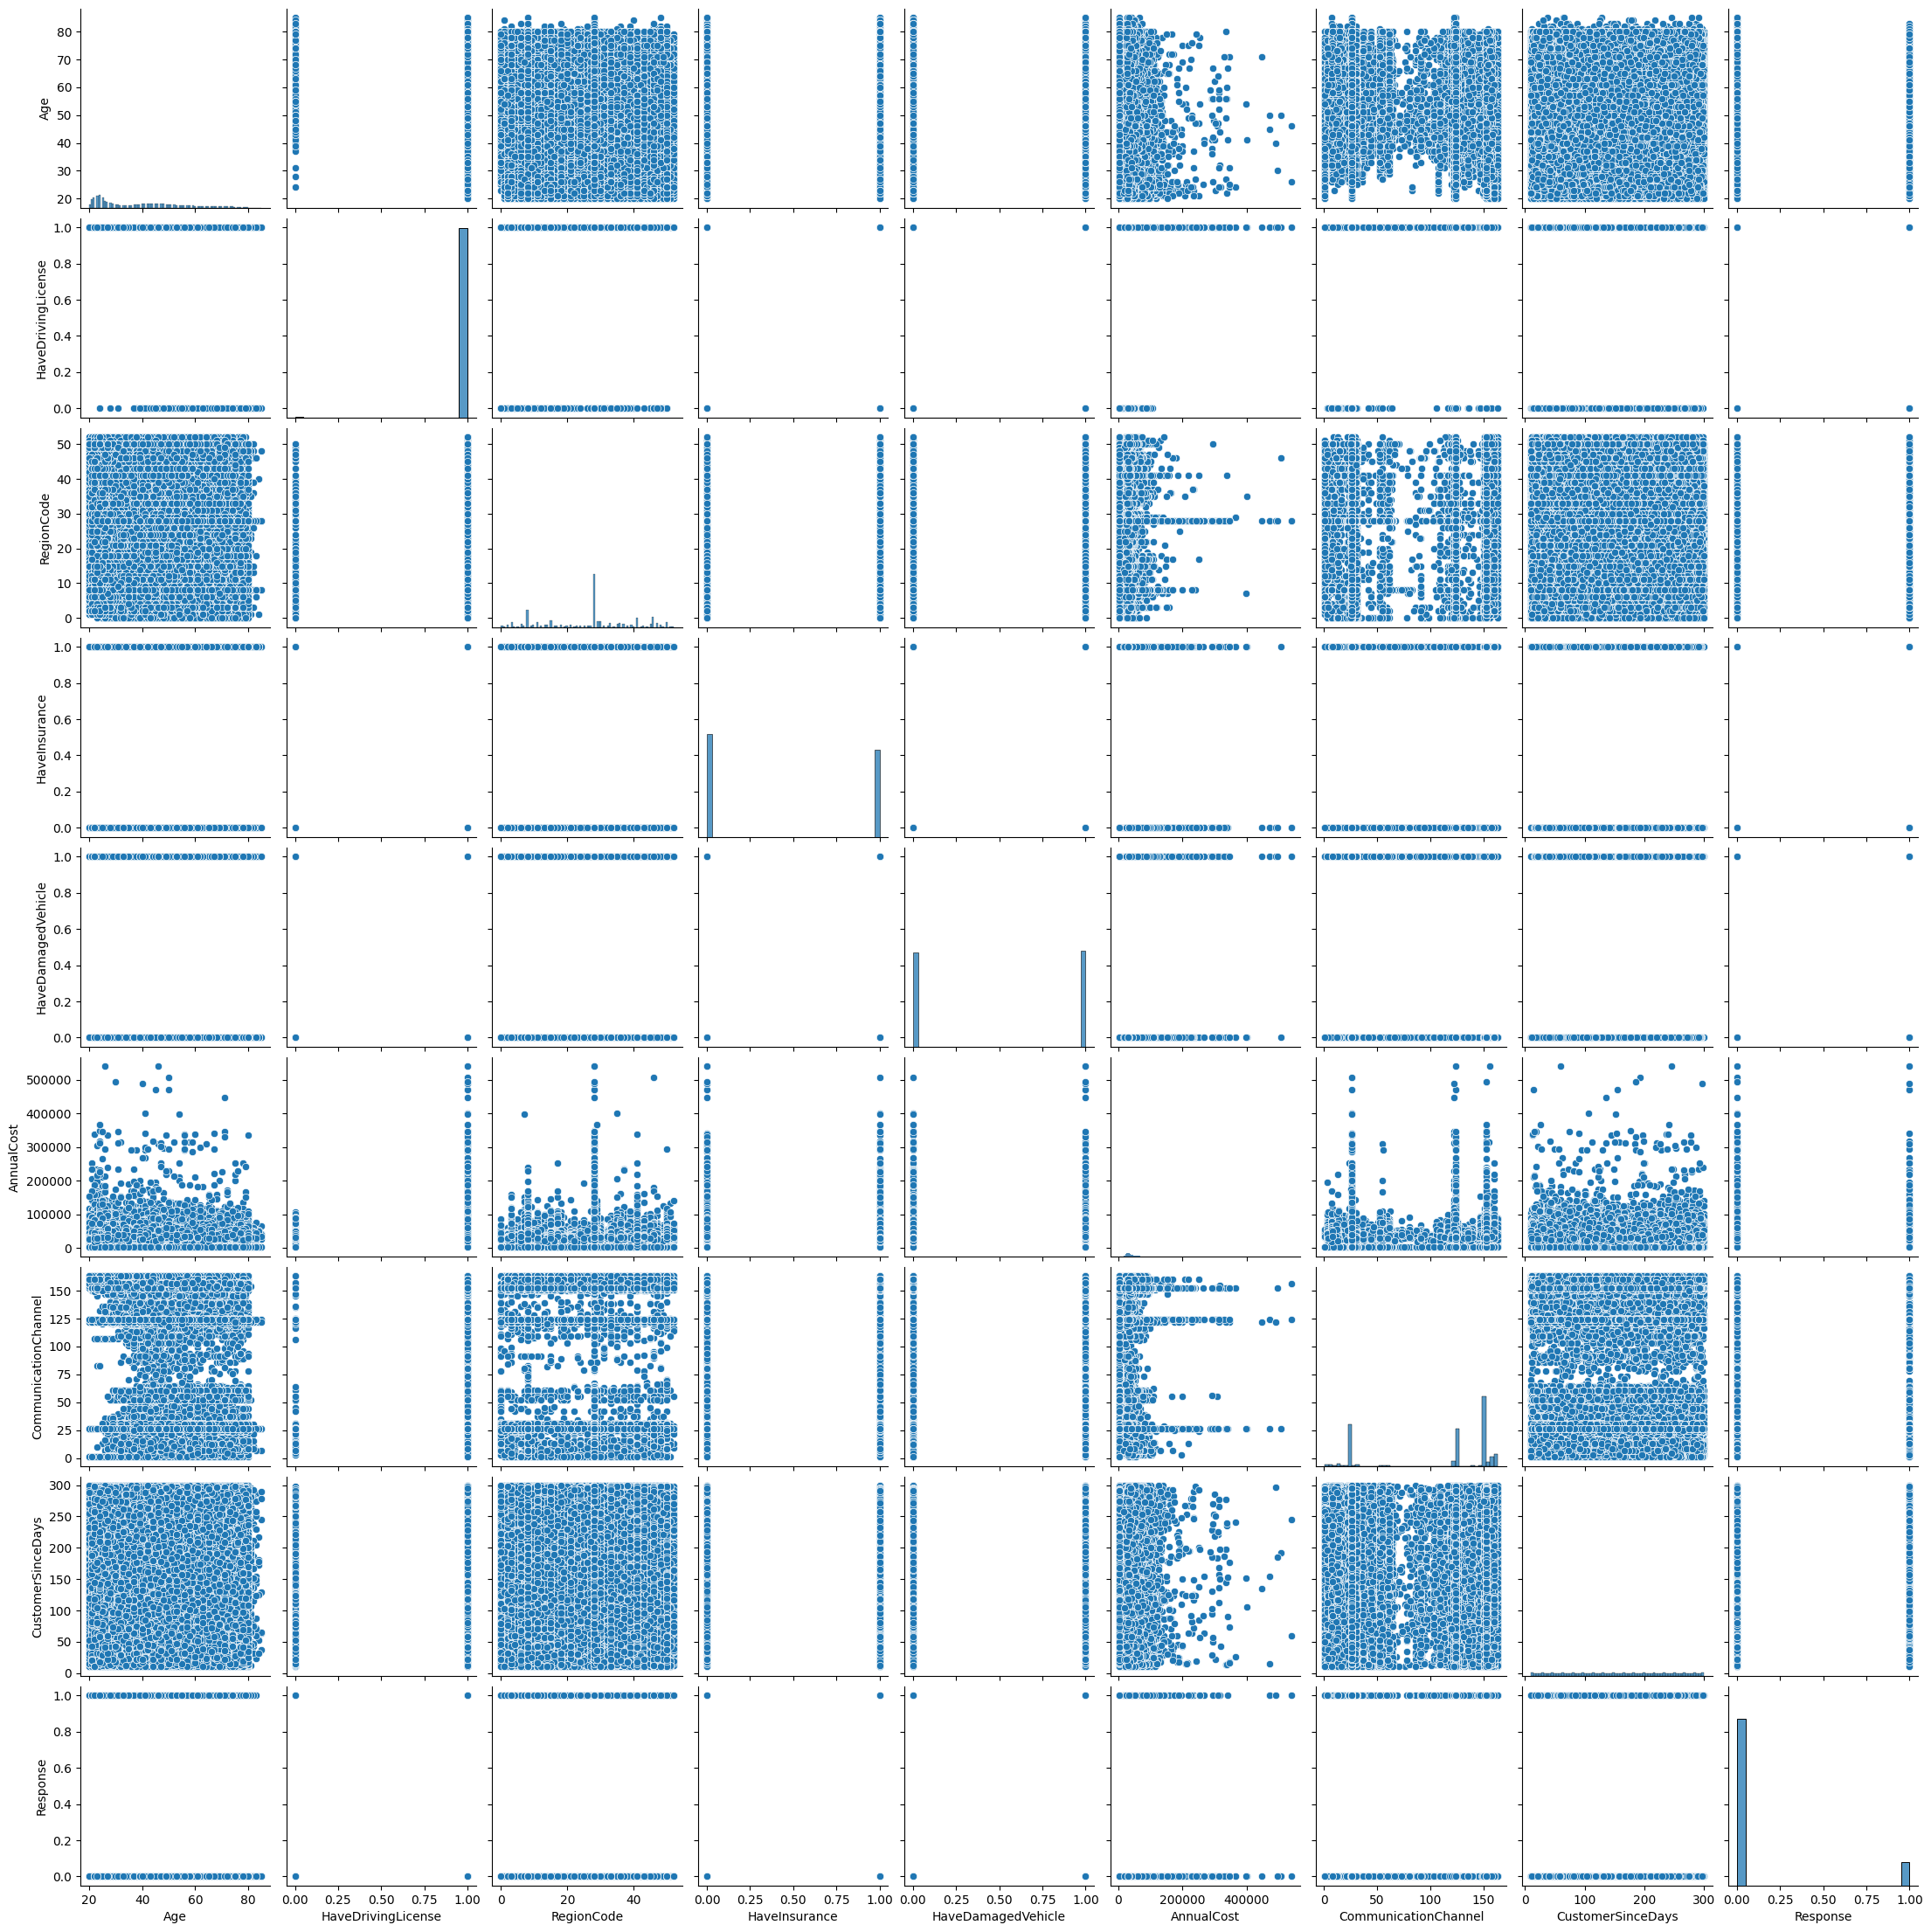

In [30]:
sns.pairplot(df4);

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

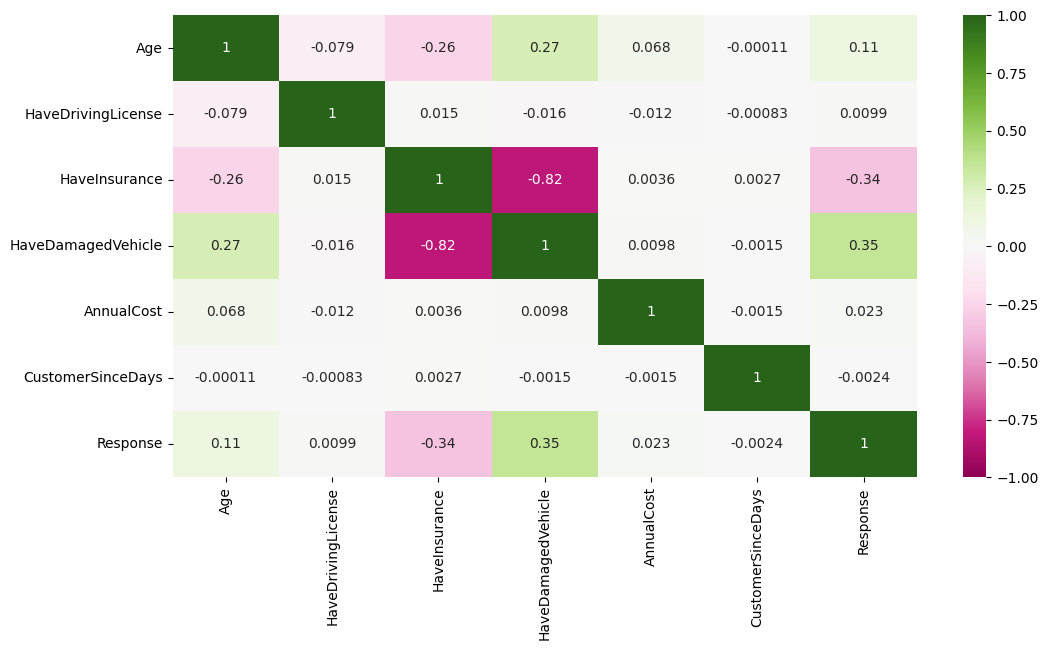

In [31]:
plt.figure(figsize = [12, 6])
sns.heatmap(df4_num.corr(), annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

### 4.3.2. Categorical Attributes

In [32]:
L = df4_cat.shape[1]
cat_corr = pd.DataFrame(np.zeros([L, L]), columns = df4_cat.columns, index = df4_cat.columns)
for i in df4_cat.columns:
    for j in df4_cat.columns:
        cat_corr.loc[i, j] = cramer_v(df4[i], df4[j])

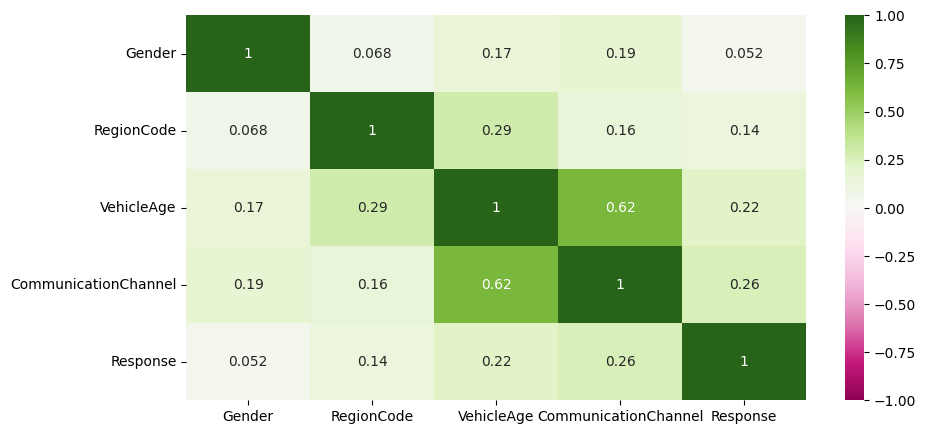

In [33]:
plt.figure(figsize = [10, 5])
sns.heatmap(cat_corr, annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

# 5. DATA PREPARATION

In [34]:
df5 = df4.copy()

## 5.1. Log Transformations

In [35]:
def log_transformation_apply(df):
    # AnnualCost
    df['AnnualCost'] = np.log1p(df['AnnualCost'])
    
    return df

## 5.2. Encoding

### 5.2.1. Label Encoding

In [36]:
# VehicleAge
le_va = LabelEncoder()
le_va.fit(df5['VehicleAge'])

def label_encoding_apply(df):
    # Gender
    df['Gender'] = df['Gender'].map({'Female': -1, "Male": 1})

    # VehicleAge
    df['VehicleAge'] = le_va.transform(df['VehicleAge'])
    
    return df

pickle.dump(le_va, open('parameter/va_encoding.pkl', 'wb'))

### 5.2.2. Frequency Encoding

In [37]:
# RegionCode
fe_dict_rc = (df5[["Age", 'RegionCode']].groupby('RegionCode').count()['Age']/df5['RegionCode'].shape[0]).to_dict()

pickle.dump(fe_dict_rc, open('parameter/fe_dict_rc_encoding.pkl', 'wb'))


# CommunicationChannel
fe_dict_cc = (df5[["Age", 'CommunicationChannel']].groupby('CommunicationChannel').count()['Age']/df5['CommunicationChannel'].shape[0]).to_dict()

pickle.dump(fe_dict_cc, open('parameter/fe_dict_cc_encoding.pkl', 'wb'))

## 5.3. Scalers

### 5.3.1. Min Max Scaler

In [38]:
# Age
mms_age = MinMaxScaler()
mms_age.fit(df5[['Age']])

# CustomerSinceDays
mms_csd = MinMaxScaler()
mms_csd.fit(df5[['CustomerSinceDays']])


def min_max_apply(df):
    # Age
    df['Age'] = mms_age.transform(df[['Age']])

    # CustomerSinceDays
    df['CustomerSinceDays'] = mms_csd.transform(df[['CustomerSinceDays']])
    
    return df

pickle.dump(mms_age, open('parameter/mms_age_scaler.pkl', 'wb'))
pickle.dump(mms_csd, open('parameter/mms_csd_scaler.pkl', 'wb'))

### 5.3.2. Standard Scaler

In [39]:
# AnnualCost
ss_annualcost = StandardScaler()
ss_annualcost.fit(df5[['AnnualCost']])

def std_scaler_apply(df):
    # AnnualCost
    df['AnnualCost'] = ss_annualcost.transform(df[['AnnualCost']])
    
    return df

pickle.dump(ss_annualcost, open('parameter/ss_annualcost.pkl', 'wb'))

## 5.4. Preparation Function

In [40]:
def data_preparation(df):
    df = log_transformation_apply(df)
    df = label_encoding_apply(df)
    df['RegionCode'] = df['RegionCode'].map(fe_dict_rc)
    df['CommunicationChannel'] = df['CommunicationChannel'].map(fe_dict_cc)
    df = min_max_apply(df)
    df = std_scaler_apply(df)
    
    return df

In [41]:
df5 = data_preparation(df5)

# 6. FEATURE SELECTION

In [42]:
df6 = df5.copy()

## 6.1. Manual Selection

In [43]:
selected_columns_manual = ['Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
       'HaveInsurance', 'VehicleAge', 'HaveDamagedVehicle', 'Response']

## 6.2. Selection

In [44]:
df6 = df6.loc[:, selected_columns_manual]

## 6.3. Data Splitting

In [45]:
train, val = train_test_split(df6, test_size = 0.25, shuffle = True, random_state = seed)

x_train = train.drop('Response', axis = 1)
y_train = train['Response']

x_val = val.drop('Response', axis = 1)
y_val = val['Response']

# 7. MACHINE LEARNING MODELLING

In [46]:
df7 = df6.copy()

In [47]:
# k defined as percentage of the validation data
k = round(0.2 * val.shape[0])

# Number of folds
n_folds = 5

## 7.1. Data Augmentation

In [48]:
smote = SMOTE(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)

x_train_aug, y_train_aug = smote.fit_resample(x_train, y_train)

## 7.2. Logistic Regression

### 7.2.1. Single Model

In [49]:
lr = LogisticRegression(random_state = seed)
lr.fit(x_train, y_train)

predict_lr = lr.predict_proba(x_val)

result_lr = ml_result(val, k, 'Logistic Regression', predict_lr)

result_lr

,Model,Precision@15244,AP@15244
0,Logistic Regression,0.290869,0.304231


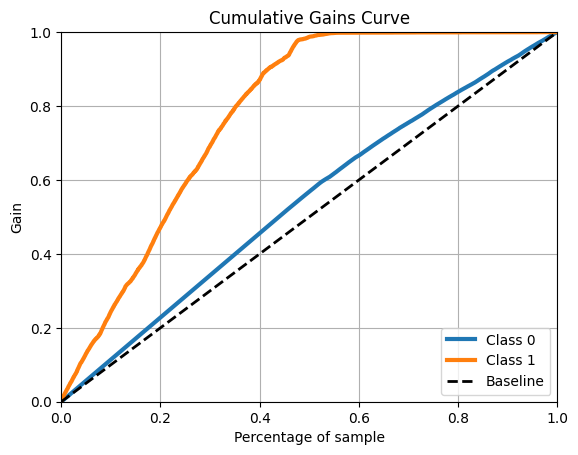

In [50]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_lr);

### 7.2.2. Cross-Validation

In [51]:
lr_cv = cross_validation(df7, n_folds, lr, "Logistic Regression", verbose = False)
lr_cv

,Model,Precision@15244,AP@15244
0,Logistic Regression,0.2890 +/- 0.0038,0.3029 +/- 0.0054


## 7.3. K-Nearest Neighbors

### 7.3.1. Single Model

In [52]:
knn = KNN()
knn.fit(x_train_aug, y_train_aug)

predict_knn = knn.predict_proba(x_val)

result_knn = ml_result(val, k, 'KNN', predict_knn)

result_knn

,Model,Precision@15244,AP@15244
0,KNN,0.302348,0.313379


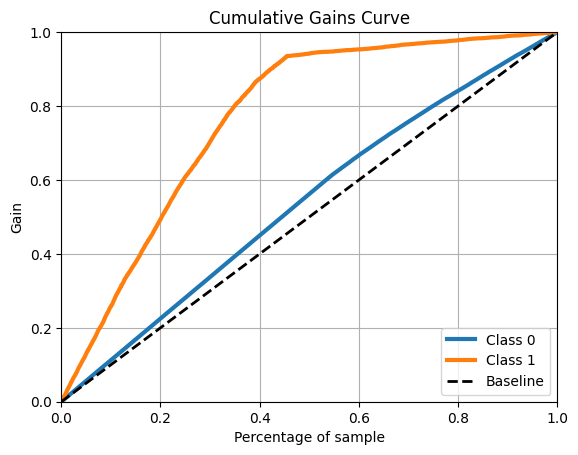

In [53]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_knn);

### 7.3.2. Cross-Validation

In [54]:
knn_cv = cross_validation(df7, n_folds, knn, "KNN", verbose = False)
knn_cv

,Model,Precision@15244,AP@15244
0,KNN,0.2817 +/- 0.0039,0.3112 +/- 0.0037


## 7.4. Random Forest

### 7.4.1. Single Model

In [55]:
rf = RF(n_jobs = -1, random_state = seed)
rf.fit(x_train_aug, y_train_aug)

predict_rf = rf.predict_proba(x_val)

result_rf = ml_result(val, k, 'Random Forest', predict_rf)

result_rf

,Model,Precision@15244,AP@15244
0,Random Forest,0.326096,0.341332


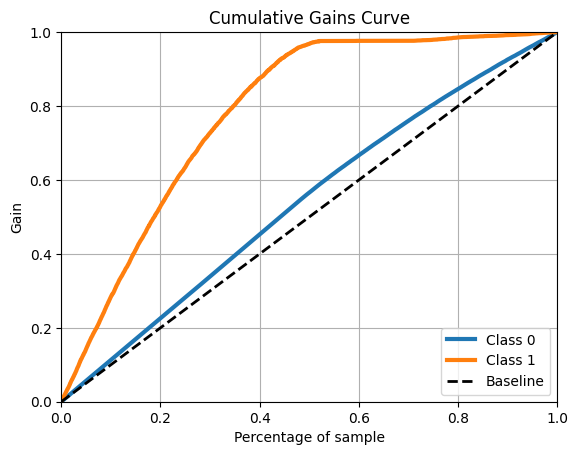

In [56]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_rf);

### 7.4.2. Cross-Validation

In [57]:
rf_cv = cross_validation(df7, n_folds, rf, "Random Forest", verbose = False)
rf_cv

,Model,Precision@15244,AP@15244
0,Random Forest,0.3160 +/- 0.0036,0.3290 +/- 0.0050


## 7.5. XGBoost

### 7.5.1. Single Model

In [58]:
xgb = xgboost.XGBClassifier(random_state = seed)
xgb.fit(x_train_aug, y_train_aug)

predict_xgb = xgb.predict_proba(x_val)

result_xgb = ml_result(val, k, "XGBoost", predict_xgb)

result_xgb

,Model,Precision@15244,AP@15244
0,XGBoost,0.33974,0.375483


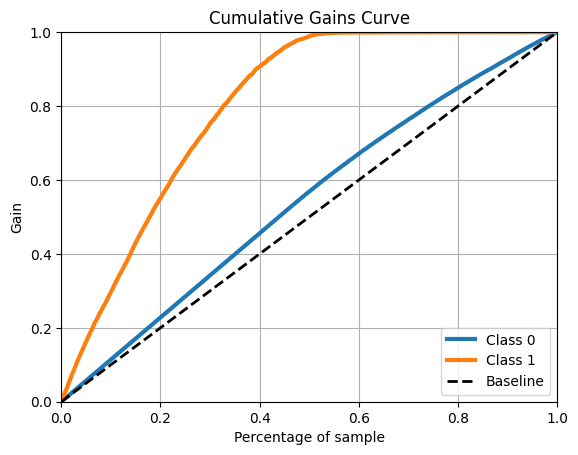

In [59]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_xgb);

### 7.5.2. Cross-Validation

In [60]:
xgb_cv = cross_validation(df7, n_folds, xgb, "XGBoost", verbose = False)
xgb_cv

,Model,Precision@15244,AP@15244
0,XGBoost,0.3280 +/- 0.0027,0.3630 +/- 0.0056


## 7.6. Results

### 7.6.1. Single Model

In [61]:
pd.concat([result_lr, result_knn, result_rf, result_xgb])

,Model,Precision@15244,AP@15244
0,Logistic Regression,0.290869,0.304231
0,KNN,0.302348,0.313379
0,Random Forest,0.326096,0.341332
0,XGBoost,0.339740,0.375483


### 7.6.2. Cross-Validation

In [62]:
pd.concat([lr_cv, knn_cv, rf_cv, xgb_cv])

,Model,Precision@15244,AP@15244
0,Logistic Regression,0.2890 +/- 0.0038,0.3029 +/- 0.0054
0,KNN,0.2817 +/- 0.0039,0.3112 +/- 0.0037
0,Random Forest,0.3160 +/- 0.0036,0.3290 +/- 0.0050
0,XGBoost,0.3280 +/- 0.0027,0.3630 +/- 0.0056


# 8. HYPERPARAMETERS FINE TUNING

In [63]:
df8 = df7.copy()

## 8.1. Random Search

In [64]:
'''
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03]                           ,
         'max_depth': [3, 5, 9]                        ,
         'subsample': [0.1, 0.5, 0.7]                  ,
         'colsample_bytree': [0.3, 0.7, 0.9]           ,
         'min_child_weight': [3, 8, 15]                 }

evals = 40

rand_search = RandomizedSearchCV(estimator = xgboost.XGBClassifier(random_state = seed), param_distributions = param, cv = 5, n_iter = evals, n_jobs = 6, verbose = 2)
rand_search.fit(x_train, y_train)
rand_search.best_params_
'''

"\nparam = {'n_estimators': [1500, 1700, 2500, 3000, 3500],\n         'eta': [0.01, 0.03]                           ,\n         'max_depth': [3, 5, 9]                        ,\n         'subsample': [0.1, 0.5, 0.7]                  ,\n         'colsample_bytree': [0.3, 0.7, 0.9]           ,\n         'min_child_weight': [3, 8, 15]                 }\n\nevals = 40\n\nrand_search = RandomizedSearchCV(estimator = xgboost.XGBClassifier(random_state = seed), param_distributions = param, cv = 5, n_iter = evals, n_jobs = 6, verbose = 2)\nrand_search.fit(x_train, y_train)\nrand_search.best_params_\n"

In [65]:
param_final = {'subsample': 0.7,
               'n_estimators': 2500,
               'min_child_weight': 15,
               'max_depth': 5,
               'eta': 0.01,
               'colsample_bytree': 0.3}

## 8.2. Model Evaluation

### 8.2.1. Single Model

In [66]:
model_eval = xgboost.XGBClassifier( n_estimators      = param_final['n_estimators']     ,
                                    eta               = param_final['eta']              ,
                                    max_depth         = param_final['max_depth']        ,
                                    subsample         = param_final['subsample']        ,
                                    colsample_bytree  = param_final['colsample_bytree'] ,
                                    min_child_weight  = param_final['min_child_weight'] ,
                                    random_state      = seed                             )
model_eval.fit(x_train, y_train)
y_hat_eval = model_eval.predict_proba(x_val)

result_eval = ml_result(val, k, 'XGBoost', y_hat_eval)

result_eval

,Model,Precision@15244,AP@15244
0,XGBoost,0.345907,0.383536


### 8.2.2. Cross-Validation

In [67]:
model_eval_cv = cross_validation(df8, 5, model_eval, "Final Model", verbose = False)
model_eval_cv

,Model,Precision@15244,AP@15244
0,Final Model,0.3301 +/- 0.0026,0.3653 +/- 0.0059


# 9. RESULT INTERPRETATION

In [68]:
df9 = df8.copy()

## 9.1. Generalization Evaluation

In [69]:
df_test = df_test_raw.copy()
df_test.columns = new_cols_name
df_test['HaveDamagedVehicle'] = df_test['HaveDamagedVehicle'].map({'Yes': 1, 'No': 0 })
df_test = data_preparation(df_test)
df_test = df_test.loc[:, selected_columns_manual]

x_test = df_test.drop('Response', axis = 1)

In [70]:
final_model = xgboost.XGBClassifier(n_estimators      = param_final['n_estimators']     ,
                                    eta               = param_final['eta']              ,
                                    max_depth         = param_final['max_depth']        ,
                                    subsample         = param_final['subsample']        ,
                                    colsample_bytree  = param_final['colsample_bytree'] ,
                                    min_child_weight  = param_final['min_child_weight'] ,
                                    random_state      = seed                             )

final_model.fit(x_train_aug, y_train_aug)

predict_final = final_model.predict_proba(x_test)

result_final = ml_result(df_test, k, "XGBoost", predict_final)

result_final

,Model,Precision@15244,AP@15244
0,XGBoost,0.340987,0.365611


In [71]:
pickle.dump(final_model, open('models/final_model.pkl', 'wb'))

## 9.2. Business Performance

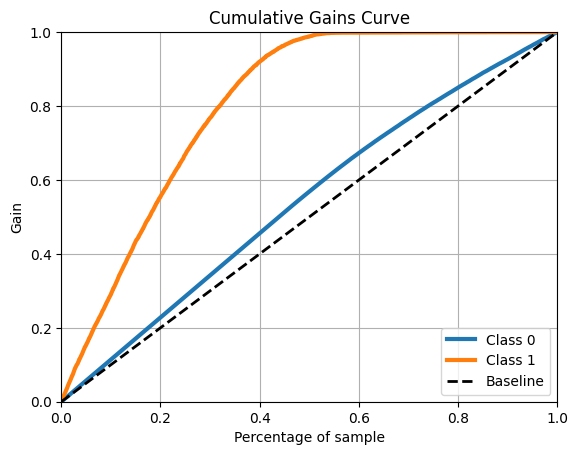

In [72]:
skplt.metrics.plot_cumulative_gain(df_test['Response'], predict_final);

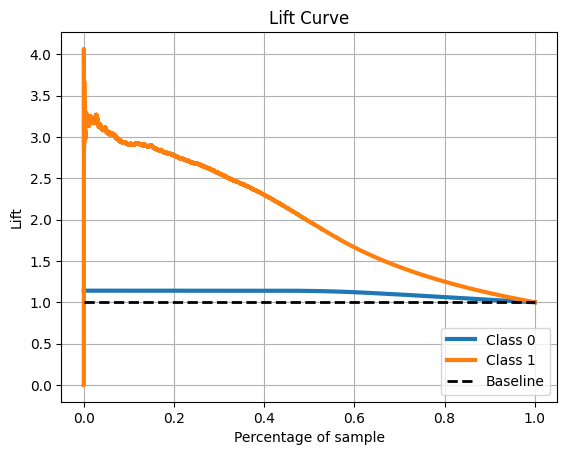

In [73]:
skplt.metrics.plot_lift_curve(df_test['Response'], predict_final);

# 10. DEPLOYMENT

## 10.1. API Tester

In [74]:
import requests
import json

json_test_raw = json.dumps(df_test_raw.drop('Response', axis = 1).to_dict(orient = 'records'))
headers = {'Content-type': 'application/json'}


response = requests.post(url = 'http://127.0.0.1:5000/cross_sell/predict', data = json_test_raw, headers = headers)
response

<Response [200]>

In [75]:
pd.DataFrame(response.json())

,Age,Annual_Premium,Driving_License,Gender,Policy_Sales_Channel,Previously_Insured,Propensity_Order,Region_Code,Vehicle_Age,Vehicle_Damage,Vintage,id
0,33,2630.0,1,Female,158.0,0,1,28.0,1-2 Year,Yes,212,3752
1,33,30379.0,1,Female,124.0,0,2,28.0,1-2 Year,Yes,152,163108
2,33,50262.0,1,Female,26.0,0,3,28.0,1-2 Year,Yes,63,378054
3,33,53294.0,1,Female,154.0,0,4,28.0,1-2 Year,Yes,225,90946
4,33,45598.0,1,Female,26.0,0,5,28.0,1-2 Year,Yes,71,142531
...,...,...,...,...,...,...,...,...,...,...,...,...
76217,75,28005.0,0,Male,22.0,1,76218,26.0,1-2 Year,No,117,72896
76218,78,43030.0,0,Male,124.0,1,76219,28.0,1-2 Year,No,282,58238
76219,78,2630.0,1,Male,26.0,1,76220,1.0,1-2 Year,No,82,4426
76220,80,50929.0,0,Male,13.0,1,76221,28.0,1-2 Year,No,162,361575
